In [2]:
import mesa
import networkx as nx
import numpy as np, pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()


In [ ]:
def compute_variance_own(model):
    agent_opinions = [agent.own_group_feeling for agent in model.schedule.agents]
    return sum(np.var(agent_opinions, axis=0))

def compute_variance_other(model):
    agent_opinions = [agent.other_group_feeling for agent in model.schedule.agents]
    return sum(np.var(agent_opinions, axis=0))

def compute_affective_polarization(agent):
    return agent.own_group_feeling - agent.other_group_feeling

def compute_agent_affect(agent):
    distances = {group : [] for group in range(agent.model.num_groups)}
    for other_agent in agent.model.schedule.agents:
      if agent.unique_id != other_agent.unique_id:
        distances[other_agent.group].append( 1 if (np.linalg.norm(agent.opinion - other_agent.opinion) <= agent.model.T) else 0)
    tolerance = [np.mean(distances[group]) for group in range(agent.model.num_groups)]
    return np.array(tolerance)

In [ ]:
class Agent(mesa.Agent):
    """
    An agent posts tweets based on its issue positions with the goal of recieveing the most likes for each tweet
    The agents issue positions get updated based on the posts that recieved the most likes in the previous round
    """

    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.issue_positions = np.clip(self.model.random.normal(self.model.means, self.model.stddevs, self.model.num_issues),
                                np.zeros(self.model.num_issues), np.ones(self.model.num_issues))
        
    def generate_post(self):
        return np.clip(self.issue_positions + self.model.random.normal(self.model.noise[0],self.model.noise[1],1), 
                np.zeros(self.model.num_issues), np.ones(self.model.num_issues))

    def get_most_liked(self):
        if self.model.timeline != None:
            max_likes = np.argmax(self.model.timeline[-1])
            max_posts = [post for post in self.model.timeline if post[-1] in set(max_likes)] 
            return max_posts
        else:
            return None

    def step(self):
        # 1. Observe rewards from previous step
        most_liked = self.get_most_liked()
        # 2. Update issue postions in line with the observed rewards
        if most_liked != None:
            self.issue_positions = self.issue_positions + self.model.R * (np.mean(most_liked[self.model.num_issues]) - self.issue_positions)
            self.issue_positions = np.clip(self.issue_positions,np.zeros(self.model.num_issues), np.ones(self.model.num_issues))
        # 3. Generate a post and add it to the timeline with probability P
        if self.model.random() <= self.model.P:
            self.model.timeline.append(self.generate_post())
        # 4. Or look at everything tha
        else:




In [589]:
class MastodonModel(mesa.Model):

    def __init__(self, N=100, I=10, T=.25, R=.25, P=.1, means=.5, stddevs = .25, seed=None):

        self.num_agents = N
        self.num_issues = I
        self.noise = [.05,.1]
        self.T = T
        self.R = R
        self.P = P
        self.means = means
        self.stddevs = stddevs
        self.timeline = None

        self.schedule = mesa.time.RandomActivation(self)
        self.random = np.random.default_rng(seed)
        self.running = True

        # Create agents
        for i in range(self.num_agents):
            a = Agent(i, self)
            self.schedule.add(a)


        
        self.datacollector = mesa.DataCollector(
           # model_reporters={"variance_own": compute_variance_own, "variance_other": compute_variance_other} , #"affect": compute_affect}, 
           # agent_reporters={"group": "group", "own_group_feeling": "own_group_feeling", "other_group_feeling": "other_group_feeling" }
        )

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

  0%|          | 0/3 [00:00<?, ?it/s]

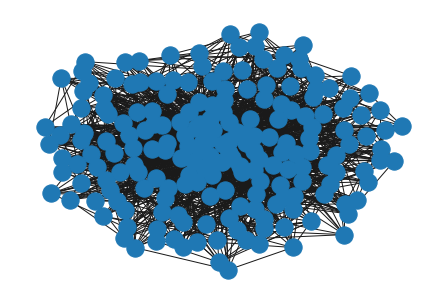

 33%|███▎      | 1/3 [00:02<00:05,  2.82s/it]

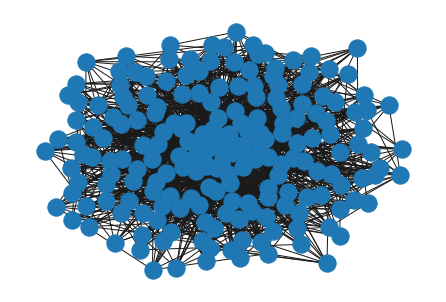

 67%|██████▋   | 2/3 [00:05<00:02,  2.72s/it]

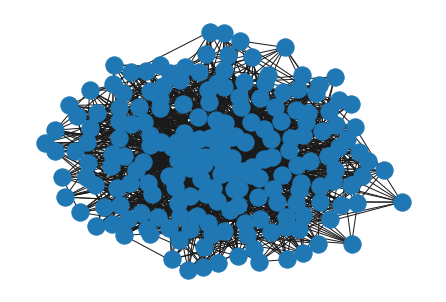

100%|██████████| 3/3 [00:08<00:00,  2.69s/it]


In [595]:
n_iters = 1
params = {"N": 200,
        "seed": 123}

results = mesa.batch_run(
    MastodonModel,
    parameters=params,
    iterations=n_iters,
    max_steps=500,
    number_processes=1,
    data_collection_period=1,
    display_progress=True,
)

results_df = pd.DataFrame(results)

In [596]:
results_df["polarization"] = results_df.own_group_feeling - results_df.other_group_feeling

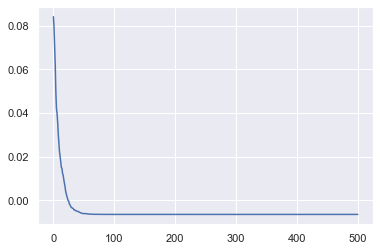

In [597]:
results2 = results_df[(results_df.RunId == runid) & (results_df.group == 0)]
plt.plot(results2.groupby("Step").polarization.agg("mean"));

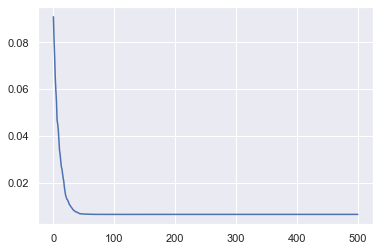

In [598]:
results0 = results_df[(results_df.RunId == runid) & (results_df.group == 1)]
plt.plot(results0.groupby("Step").polarization.agg("mean"));

In [510]:
runid = 0

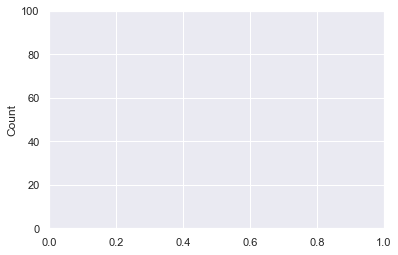

In [607]:
step = 500
results10 = results_df[(results_df.RunId == runid) & (results_df.Step == step) & (results_df.group == 0)] 
results11 = results_df[(results_df.RunId == runid) & (results_df.Step == step) & (results_df.group == 1)]
sns.histplot([ float(value) for value in results10.own_group_feeling.values], color="b")#, bins = 15) 
sns.histplot([ float(value) for value in results11.own_group_feeling.values], color="r")#, bins = 15)
plt.axis([0, 1, 0, 100]);
#sns.histplot([ float(value) for value in results12.opinion.values], color="g", bins = 15); 

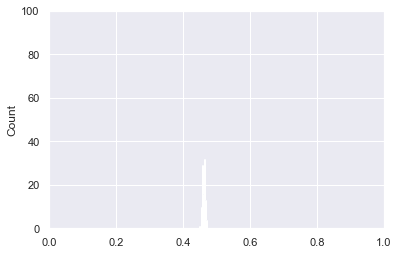

In [611]:
step = 50
results10 = results_df[(results_df.RunId == runid) & (results_df.Step == step) ] 
results11 = results_df[(results_df.RunId == runid) & (results_df.Step == step) ]
sns.histplot([ float(value) for value in results10.other_group_feeling.values], color="b", bins = 15) 
#sns.histplot([ float(value) for value in results11.opinion.values], color="r", bins = 15)
plt.axis([0, 1, 0, 100]);

In [502]:
step = 500
results10 = results_df[(results_df.RunId == runid) & (results_df.Step == step) ] 
np.corrcoef([ float(value) for value in results10.own_group_feeling.values], [ float(value) for value in results10.other_group_feeling.values])

/Users/yara/opt/miniforge3/envs/ml/lib/python3.9/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]


array([[nan, nan],
       [nan, nan]])

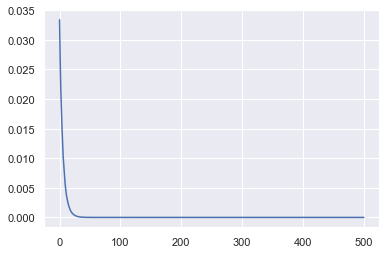

In [612]:
plt.plot(results_df[(results_df.RunId == runid) & (results_df.AgentID == 1) ].variance_own.values);

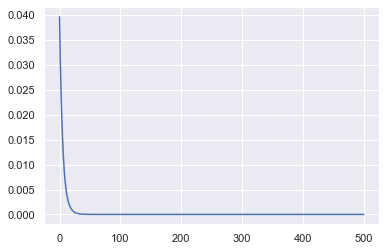

In [613]:
plt.plot(results_df[(results_df.RunId == runid) & (results_df.AgentID == 1) ].variance_other.values);

In [578]:
model = ARMModel(N=200)